# Partial Differential Equation resolution through a Monte-Carlo simulation

## Monte-Carlo Resolution of Laplace's equation on $[0,1]^{2}$

### Initial problem set : a Laplacian Dirichlet problem

The initial problem is the following : 
<br>
We are given a compact 2-dimensional set $\mathbb{D} = [0, 1]^{2} \subset \mathbb{R}^{2}$,
and a boundary function regular function $\varphi$ defined on the border of $\mathbb{D}$.
<br>
We consider the Dirichlet problem defined by the following Laplace's equation :
$$\forall (x,y) \in \mathbb{D} ,  \frac{\partial ^{2} f}{\partial x^{2}}(x,y) + \frac{\partial ^{2} f}{\partial y^{2}}(x,y) = 0$$
and the Dirichlet boundary condition :
$$\forall (x,y) \in \partial \mathbb{D}, f(x,y) = \varphi(x,y)$$
This equation is commonly encountered in a number of branches of physics : electrostatics, gravitation, and fluid dynamics.
<br>
We can also interpret is as a steady-state heat equation : $f(x,y)$ would be the temperature at coordinates x and y in a given square $\mathbb{D}$ whose border temperatures are kept constant (and equal to $\varphi$ in the border). The objective, in this case, is to deduce the temperature $f(x,y)$ in all points $(x,y)$ inside the 2D square.
<br>

### A stochastic approach to resolving the Dirichlet problem

To make this situation numerically approachable, we start off by discretizing the $\mathbb{D} = [0, 1]^{2}$ square into an $(L+1) * (L+1)$ grid of integer coordinates $(i,j)$, which we denote as $\mathbb{E} = \{0, 1, .., L\}^2$, and setting a function $u$ defined on $\mathbb{E}$ such that :
$$\forall (i,j) \in \mathbb{E}, u(i,j) \text{  corresponds to  }f(\frac{j}{L}, \frac{i}{L})$$
<br>
To discretize a second derivative of f, we use the following idea :
$$f(\frac{j+1}{L}, \frac{i}{L}) - f(\frac{j}{L}, \frac{i}{L}) = \frac{1}{L} \frac{\partial f}{\partial x}(\frac{j}{L}, \frac{i}{L}) + \frac{1}{2L^{2}} \frac{\partial ^{2} f}{\partial x^{2}}(\frac{j}{L}, \frac{i}{L}) + O(\frac{1}{L^{3}})$$
$$\text{and } f(\frac{j-1}{L}, \frac{i}{L}) - f(\frac{j}{L}, \frac{i}{L}) = - \frac{1}{L} \frac{\partial f}{\partial x}(\frac{j}{L}, \frac{i}{L}) + \frac{1}{2L^{2}} \frac{\partial ^{2} f}{\partial x^{2}}(\frac{j}{L}, \frac{i}{L}) + O(\frac{1}{L^{3}})$$
which gives us by summing both equalities and isolating the second derivative :
$$\frac{\partial ^{2} f}{\partial x^{2}}(\frac{j}{L}, \frac{i}{L}) \approx L^{2} \bigg[ f(\frac{j+1}{L}, \frac{i}{L}) + f(\frac{j-1}{L}, \frac{i}{L}) - 2 f(\frac{j}{L}, \frac{i}{L}) \bigg] $$
meaning that $\frac{\partial ^{2} f}{\partial x^{2}}(\frac{j}{L}, \frac{i}{L})$ corresponds to
$$ L^{2} \bigg[ u(i,j+1) + u(i,j-1) - 2 u(i,j) \bigg]$$
Similarly, $\frac{\partial ^{2} f}{\partial y^{2}}(\frac{j}{L}, \frac{i}{L})$ corresponds to 
$$ L^{2} \bigg[ u(i+1,j) + u(i-1,j) - 2 u(i,j) \bigg]$$
The discretized Dirichlet problem consists, therefore, in finding $u$ such that :
$$\forall (i,j) \in \{1,..,L-1\}^{2} \qquad u(i,j) = \frac{1}{4} \bigg[ u(i,j+1) + u(i,j-1) + u(i+1,j) + u(i-1,j)  \bigg] $$
$$ \forall (i,j) \text{ s.t. } i=0\text{ or }j=0\text{ or }i=L\text{ or }j=L, \qquad u(i,j) = \varphi(\frac{j}{L}, \frac{i}{L})$$
To numerically solve this 2D recurrent problem, we use a stochastic approach : to find $u(i,j)$, we initialize $K \in \mathbb{N}$ random walks at $X_0 = (i,j)$ for $(i,j) \in \{1,..,L-1\}^{2}$, and at each step, the variable $X_{n+1}$ uniformly goes to one of $X_n$'s four neighbors, until it reaches the border at step $T_{\partial \mathbb{E}}$ with $\partial \mathbb{E} = \bigg\{ (i,j) \text{ s.t. } i=0\text{ or }j=0\text{ or }i=L\text{ or }j=L \bigg\}$. At that point, we save the value $\varphi(X_{T_{\partial \mathbb{E}}})$.
<br> 
Knowing that $\mathbb{E}\big[ \varphi(X_{T_{\partial \mathbb{E}}}) \big| X_0 = (i,j) \big] = u(i,j)$, we must choose a $K$ large enough that the error $\bigg| u(i,j) - \frac{1}{K} \sum_{k=1}^K {\varphi(X_{T_{\partial \mathbb{E}}}^{(k)})} \bigg|$ is negligible. We will attempt different values of $K$ to empirically choose a fitting value K, knowing that the algorithm's time complexity is, in terms of $K$, $O(K)$

### Implementation of the algorithm

In [1]:
##Importing relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import json
from statistics import mean
import seaborn as sns
from concurrent import futures
import os
#from multiprocessing import Pool, freeze_support, cpu_count
from multiprocess import Pool, freeze_support, cpu_count


We define the main function which will allow us to compute a numerical approximation of $u(i,j)$ for all $(i,j)$ in $\mathbb{E}$ :

In [43]:
def fill_U_Laplace(U : np.array, phi : callable, K : int, genCoordinateList : callable) -> None :
    """
    Fills the array U with the values U[i,j] corresponding to the values f(x,y) where x=j/L and y=i/L.
    Inputs :
        U : np.array of floats, its dimension is (L+1) * (L+1)
        phi : callable function which takes in as argument (x,y) and returns the border value phi(x,y)
        K : number of random walks to execute starting at each cell of U
        randomWalk_out : a callable function which simulates a Markov chain starting at X_0 = (i0, j0) and finishing at the border of the array
    """
    L = len(U)-1 #L+1 = len(U)
    coordinateList = genCoordinateList(L) 
    for k_coord in range(len(coordinateList)) :
        (i0,j0) = coordinateList[k_coord]
        values_at_i0_j0 = [] #Contains the number of values phi(X_n) where X_T=(i_T, j_T) is in the border, after a random walk starting at (i,j)

        for i_randomWalk in range(K):
            X_T = randomWalk_out_Laplace(U,i0,j0)
            i_T, j_T = X_T[0],X_T[1]
            values_at_i0_j0.append(phi(j_T/L, i_T/L))

        U[i0,j0] = mean(values_at_i0_j0)
        print("Finished the last random walk at coordinate "+str( (i0,j0) )+" which is the coordinate #"+str(k_coord+1)+"/"+str(len(coordinateList)), end='\r')
    print('')
        

We then define auxiliary functions :

In [3]:
def gen_U(L):
    return np.array([[0. for j in range(L)] for i in range(L)]) #We make sure it's an array of FLOATS

In [4]:
def genCoordinateList_dummy(L) : 
    """
    Returns a coordinate list of the right size (L+1) x (L+1), in an arbitrary order (line by line, and in each line, from left to right)
    """
    output = []
    for i in range(L+1):
        for j in range(L+1):
            output.append((i,j))
    return output

In [5]:
def reached_borders(U,currCoord): #currCoord is the same as X
    L = len(U)-1
    i,j = currCoord[0], currCoord[1]
    return (i*j==0 or i==L or j==L)

def randomWalk_out_Laplace(U,i0,j0):
    L = len(U)-1
    X = np.array([i0,j0]) #current coordinate
    directionList = np.array([[+1,0],
                             [-1,0],
                             [0,+1],
                             [0,-1]])
    while not reached_borders(U,X) :
        random_direction = directionList[np.random.randint(0,4)]
        X = X + random_direction
    return X


def wrapped_randomWalk_out_Laplace(args):
    return randomWalk_out_Laplace(*args)

We want to plot the solution grid $U$ as a heatmap, and save it using the json library. As such, we define a final function :

In [42]:
def plot_and_save_Laplacian(L,K):
    ## Creating a matrix U containing the values of f on the grid
    U = gen_U(L)
    fill_U_Laplace(U, phi_1, K, genCoordinateList_dummy)


    ## Plotting a heatmap of U
    my_cmap = sns.color_palette("coolwarm")
    ax = plt.axes()
    sns.heatmap(U,cmap='jet',ax=ax,square=True)
    ax.set_title("Heatmap in Laplacian case for K={K} L={L} ".format(K=K,L=L))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    #Saving as a file, indicating the values of L and K
    output_file_name = "./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_K={K}_L={L}.json".format(K=K,L=L)
    print(output_file_name)
    os.makedirs("./monteCarlo_json_dump/",exist_ok=True)
    with open(output_file_name ,"w") as output_file:
            json.dump(U.tolist(),output_file,indent=2)

To test our algorithm, we must define a border condition function $\varphi_1$. We settle on one where the vertical borders are a source of heat ($\varphi_1 = 1$) and where the horizontal borders are a source of cold ($\varphi_1 = 0$). We implement it as follows :

In [6]:
def phi_1(x,y,eps=0.0001) :
    distance_to_left_border = abs(x)
    distance_to_right_border = abs(1-x)
    distance_to_upper_border = abs(1-y)
    distance_to_lower_border = abs(y)
    if (distance_to_left_border<=eps or distance_to_right_border<=eps) : #We're at a vertical border
        return 1
    elif (distance_to_upper_border<=eps or distance_to_lower_border<=eps) : #We're at a horizontal border
        return 0
    else: #This shouldn't happen !
        assert 0==1, "phi_1 was applied to a coordinate (x,y) which isn't at the border of [0,1] x [0,1]"
        return None

We apply the algorithm for a given set of values of L and K :

In [32]:
## Setting the parameters
listL = [80]
listK = [3, 6, 12, 24, 40, 80, 120, 160]

Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


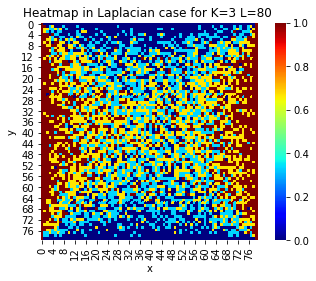

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_K=3_L=80.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


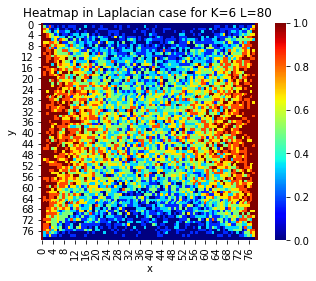

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_K=6_L=80.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


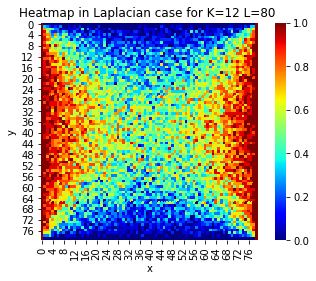

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_K=12_L=80.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


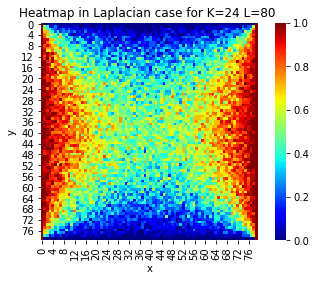

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_K=24_L=80.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


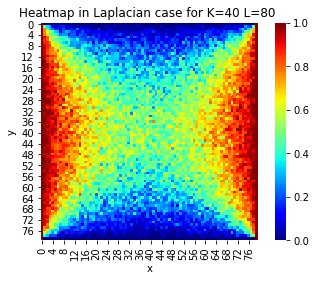

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_K=40_L=80.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


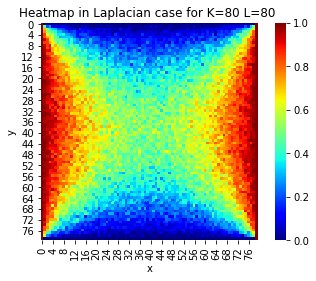

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_K=80_L=80.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


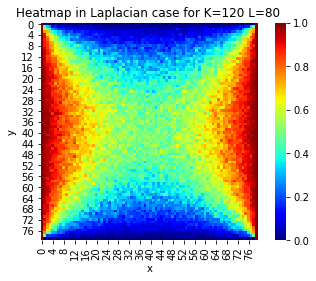

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_K=120_L=80.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


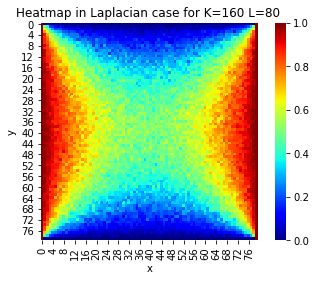

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_K=160_L=80.json

Wall time: 6h 10min 38s


In [33]:
%%time
for L in listL :
    for K in listK :
        plot_and_save_Laplacian(L,K)
print('') #To make sure the %%time output is written on a new line

We observe that starting from K=80, we do not obtain a significantly better heatmap.
Therefore parameters K = 80 and L = 80 are appropriate and will be used for the next part as well.

# Solving another type of partial differential equations 

We now consider the Dirichlet problem defined by the PDE :
$$\forall (x,y) \in \mathbb{D} ,  \frac{\partial ^{2} f}{\partial x^{2}}(x,y) + \frac{\partial ^{2} f}{\partial y^{2}}(x,y) = \gamma f(x,y) $$
and the Dirichlet boundary condition :
$$\forall (x,y) \in \partial \mathbb{D}, f(x,y) = \varphi(x,y)$$
where $\gamma \geq 0$.
<br>
From a physics point of view, this equation would represent a steady-state equation (no time variable) in 2D, where there is a constant "disparition" or "disintegration" of $f(x,y)$ at a 'rate' $\gamma$. For instance, this would be the equation we encounter in the case of particle diffusion with a constant disintegration of said particles (represented by the new term $\gamma f(x,y)$).
<br>
Another (less natural) way to visualize this, in the case of heat equations, is that at any given moment, part of the heat is lost inside the square (and must be compensated with the heat transfer coming from the borders). Therefore, we expect the inside of the square to be colder than in the previous situation, if we don't change the border conditions.
<br>
We keep the same idea as before : initializing $K$ random walks at $(i,j)$, except that now, there is a probability $\alpha$, at each step, that the walking variable $X_n$ "falls into a pit and gets stuck there". In that case, we save the value of $\varphi(X_n) = 0$ and move on to the next random walk.
<br>
In order to pick the right probability $\alpha$, we derive the following equation : $$\alpha = \frac {\gamma}{\gamma + 4 L^2}$$

In [44]:
def fill_U_Laplace_modified(U : np.array, phi : callable, K : int, genCoordinateList : callable, gamma : float) -> None :
    """
    Fills the array U with the values U[i,j] corresponding to the values f(x,y) where x=j/L and y=i/L.
    Inputs :
        U : np.array of floats, its dimension is (L+1) * (L+1)
        phi : callable function which takes in as argument (x,y) and returns the border value phi(x,y)
        K : number of random walks to execute starting at each cell of U
        randomWalk_out : a callable function which simulates a Markov chain starting at X_0 = (i0, j0) and finishing at the border of the array
        gamma : a float representing the parameter gamma of the partial differential equation
    """
    L = len(U)-1 #L+1 = len(U)
    coordinateList = genCoordinateList(L) 
    for k_coord in range(len(coordinateList)) :
        (i0,j0) = coordinateList[k_coord]
        values_at_i0_j0 = [] #Contains the number of values phi(X_n) where X_T=(i_T, j_T) is in the border, after a random walk starting at (i,j)
        for i_randomWalk in range(K):
            X_T = randomWalk_out_Laplace_mod(U,i0,j0, gamma)
            i_T, j_T = X_T[0],X_T[1]
            if (i_T,j_T) == (None,None): ##The random walk led to the pit
                values_at_i0_j0.append(0)
            else:
                values_at_i0_j0.append(phi(j_T/L, i_T/L))
        U[i0,j0] = mean(values_at_i0_j0)
        print("Finished the last random walk at coordinate "+str( (i0,j0) )+" which is the coordinate #"+str(k_coord+1)+"/"+str(len(coordinateList)), end='\r')
    print('')
        
    

In [37]:
def randomWalk_out_Laplace_mod(U,i0,j0,gamma):
    L = len(U)-1
    X = np.array([i0,j0]) #current coordinate
    alpha = gamma/(gamma+4*L*L)
    directionList = np.array([[+1,0],
                             [-1,0],
                             [0,+1],
                             [0,-1]])
    while not reached_borders(U,X) :
        if np.random.random()<alpha: #The random walk ends up in the pit
            return np.array([None,None])
        else:
            random_direction = directionList[np.random.randint(0,4)]
            X = X + random_direction
    return X

We test out a large range of $\gamma$ values, keeping the same $L$ and $K$ as before.

In [38]:
## Setting the parameters
listL = [80]
listK = [80]
listGamma = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]



In [40]:
def plot_and_save_Laplacian_mod(L,K,gamma) :
    ## Creating a matrix U containing the values of f on the grid
    U = gen_U(L)
    fill_U_Laplace_modified(U, phi_1, K, genCoordinateList_dummy, gamma)

    ## Plotting a heatmap of U
    my_cmap = sns.color_palette("coolwarm")
    ax = plt.axes()
    sns.heatmap(U,cmap='jet',ax=ax,square=True)
    ax.set_title("Heatmap in modified Laplacian case for K={K} L={L} Gamma = {gamma} ".format(K=K,L=L, gamma=gamma))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    #Saving as a file, indicating the values of L and K
    output_file_name = "./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K={K}_L={L}_gamma={gamma}.json".format(K=K,L=L,gamma=gamma)
    print(output_file_name)
    os.makedirs("./monteCarlo_json_dump/",exist_ok=True)
    with open(output_file_name ,"w") as output_file:
            json.dump(U.tolist(),output_file,indent=2)

Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


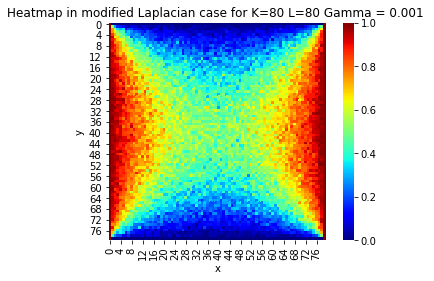

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=0.001.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


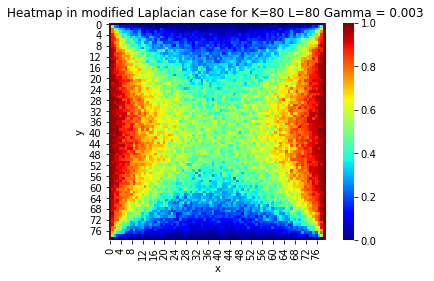

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=0.003.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


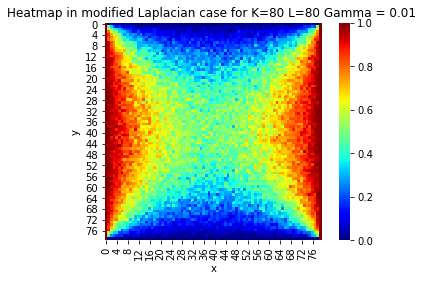

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=0.01.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


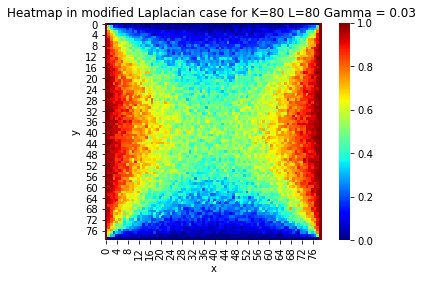

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=0.03.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


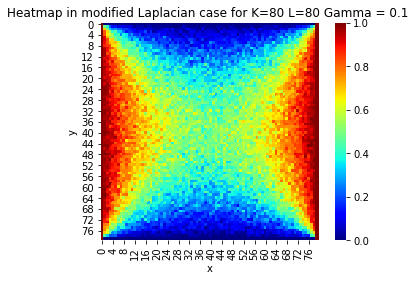

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=0.1.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


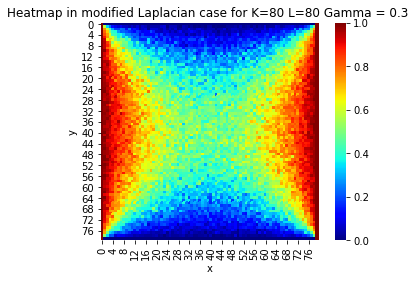

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=0.3.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


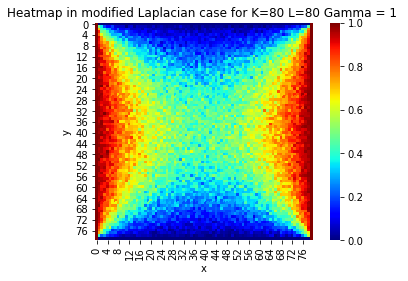

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=1.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


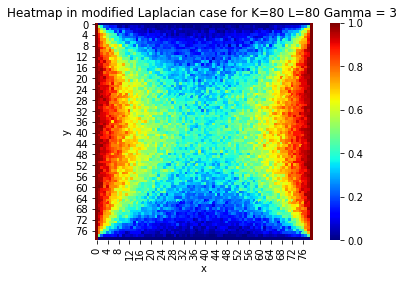

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=3.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


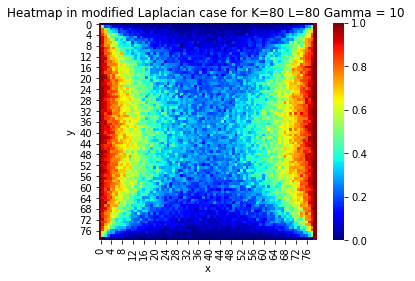

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=10.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


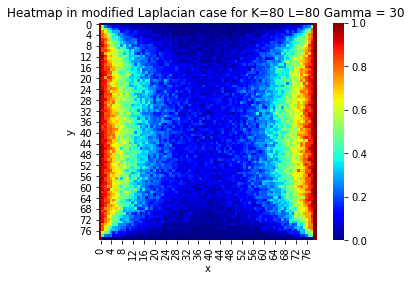

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=30.json
Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


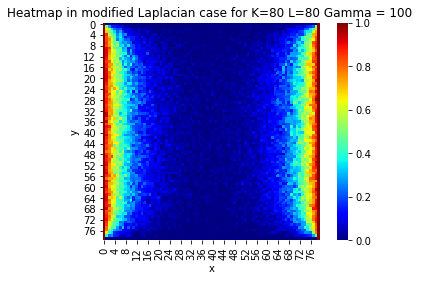

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=100.json


In [39]:
for gamma in listGamma:
    for L in listL:
        for K in listK:
            plot_and_save_Laplacian_mod(L,K,gamma)

Finished the last random walk at coordinate (79, 79) which is the coordinate #6399/6400


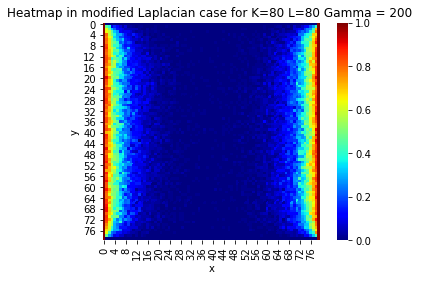

./monteCarlo_json_dump/monteCarlo_heatMap_Laplacian_modified_K=80_L=80_gamma=200.json


In [41]:
plot_and_save_Laplacian_mod(L=80,K=80,gamma=200)

We notice that in the case of very high values of $\gamma$, the inside of the square is "extremely cold" : that observation is coherent with our previous intuition about the physics interpretation of the partial differential equation.

## Ideas to make our algorithm converge faster

### Parallelized computing

The idea is simple : we have multiple for loops which are independent one from another. Therefore, the execution can be many times faster if we run them on different CPU cores.

### Using previously computed values of $u(i,j)$

For instance, if we compute $u(3,3)$ after averaging the result $K$ iterations (as described earlier), and then we initialize a random walk at $(3,4)$ and end up at some point in $(3,3)$, we can stop the random walk right there and simply use the value $u(3,3)$ as reference. 
<br>
This would speed up the process a lot, but seems to present one downside : if $u(3,3)$'s computed average is far enough from the real value, then this "high error" will continue to contaminate neighboring cells and worsen their errors. Therefore, this optimization would need to come with a higher value of $K$ to make sure that the first errors (that will get spread to neighboring cells) are very low.

### Using a different order/pattern of grid search

In the implementation we coded, the order of the grid search didn't matter, as the computations of u(i,j) were independent. However, if we implement the previous idea, it can be interesting to think of a different order in which the $(L+1)^2$ coordinates are visited. Notably, the convergence is made faster the closer "newly visited cells" are to "previously computed cells". In that regard, two natural ideas that come to mind are to :
- start at the center, then go through the surrounding 3x3 square border, then the surrounding 5x5 square border...
- start at the $(L+1)^2$ square border, then the $(L-1)^2$ square border inside of it, ... (though intuitively, it seems that this idea requires a very high value to K, to make sure that the cells close to the border don't simply average to the value at the border right next to them).